# load_ext

In [66]:
%load_ext magic_markdown
%load_ext sql
%load_ext jupyter_spaces
%load_ext blackcellmagic
%load_ext watermark
%load_ext heat

The magic_markdown extension is already loaded. To reload it, use:
  %reload_ext magic_markdown
The sql extension is already loaded. To reload it, use:
  %reload_ext sql
The jupyter_spaces extension is already loaded. To reload it, use:
  %reload_ext jupyter_spaces
The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
The heat extension is already loaded. To reload it, use:
  %reload_ext heat


# data preprocessing

In [67]:
# def merge_adjacent(arr, n):
#     # 合并相邻的相同元素
#     merged_arr = []
#     i = 0
#     while i < len(arr):
#         j = i + 1
#         while j < len(arr) and arr[j] == arr[i]:
#             j += 1
#         merged_arr.append(arr[i])
#         i = j
#     # 重复元素 n 次
#     repeated_arr = []
#     for elem in merged_arr:
#         repeated_arr.extend([elem] * n)
#     return repeated_arr
# # 打开文件，按行读取内容，并将每行内容添加到一个数组中
# with open("ztest.txt", "r") as file:
#     lines = file.readlines()
#     lines = [line.strip() for line in lines]

# # 输出读取到的内容数组
# print(lines)

# # 示例代码
# arr = lines
# print(merge_adjacent(arr, 64))
# arr=merge_adjacent(arr, 64)
# # 打开文件，写入数组中的每个元素，并在每个元素后添加一个换行符
# with open("output.txt", "w") as file:
#     for line in arr:
#         file.write(line + "\n")

In [68]:
import pandas as pd
import numpy as np


def read_xlsx(file_path):
    """
    Reads an xlsx file and returns it as a Pandas dataframe.

    Args:
        file_path (str): The path to the xlsx file.

    Returns:
        pd.DataFrame: A Pandas dataframe representing the xlsx data.
    """
    df = pd.read_excel(file_path)
    return df


file_path = "corr_uu_gamma5_Px0Py0Pz0_conf15000-17450.xlsx"
df = read_xlsx(file_path)
df.info()

# df=df.astype("Float32")
# df['data_name']=df['data_name'].astype('int')
# df['data_num']=df['data_num'].astype('int')
df_list=[df.iloc[i*len(df['data_num'].unique()):(i+1)*len(df['data_num'].unique())] for i in range(len(df['data_name'].unique()))]

for i in range(len(df_list)):
    df_list[i]=df_list[i].reset_index(drop=True)
    df0=df_list[i][(df['data_num']>=1)&(df['data_num']<=32)].reset_index(drop=True)
    df1=df_list[i][(df['data_num']>=32)&(df['data_num']<=63)][::-1].reset_index(drop=True)
    df0['data_real']=(df0['data_real']+df1['data_real'])/2
    df0['data_imag']=(df0['data_imag']+df1['data_imag'])/2
    df_list[i]=df0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   data_name  3200 non-null   int64  
 1   data_num   3200 non-null   int64  
 2   data_real  3200 non-null   float64
 3   data_imag  3200 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 100.1 KB


/tmp/ipykernel_73698/583674184.py:30: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df0=df_list[i][(df['data_num']>=1)&(df['data_num']<=32)].reset_index(drop=True)
/tmp/ipykernel_73698/583674184.py:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1=df_list[i][(df['data_num']>=32)&(df['data_num']<=63)][::-1].reset_index(drop=True)


# jackknife

In [69]:
import numpy as np
# def jackknife(arr):
#     arr = np.array(arr)
#     n = len(arr)
#     jk_mean = np.zeros(n)
#     for i in range(n):
#         jk_mean[i] = np.mean(np.delete(arr, i))
#     jk_std = np.sqrt((n - 1) / n * np.sum((jk_mean - np.mean(jk_mean)) ** 2))
#     return jk_mean, jk_std

def jackknife(arr):
    arr = np.array(arr)
    n = len(arr)
    jk_mean = (np.sum(arr) - arr) / (n - 1)
    return pd.DataFrame({'mean':jk_mean, 'std':[np.sqrt((n - 1))*np.std(jk_mean)]*n})
arr = np.array([1,2,3,4,5])
# arr = df["data_real"][0:64]
# print(arr)
jk_all = jackknife(arr)
print("Jackknife mean:", jk_all['mean'])
print("Jackknife std:", jk_all['std'])

Jackknife mean: 0    3.50
1    3.25
2    3.00
3    2.75
4    2.50
Name: mean, dtype: float64
Jackknife std: 0    0.707107
1    0.707107
2    0.707107
3    0.707107
4    0.707107
Name: std, dtype: float64


# apply_func_to_col

In [70]:
jk_real_all = [
    jackknife([j.iloc[i]["data_real"] for j in df_list])
    for i in range(df_list[0].shape[0])
]
jk_imag_all = [
    jackknife([j.iloc[i]["data_imag"] for j in df_list])
    for i in range(df_list[0].shape[0])
]
for k in range(len(df_list)):
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_real",
        [jk_real_all[i]["mean"][k] for i in range(df_list[0].shape[0])],
    )
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_real_std",
        [jk_real_all[i]["std"][k] for i in range(df_list[0].shape[0])],
    )
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_imag",
        [jk_imag_all[i]["mean"][k] for i in range(df_list[0].shape[0])],
    )
    df_list[k].insert(
        df_list[k].shape[1],
        "jk_imag_std",
        [jk_imag_all[i]["std"][k] for i in range(df_list[0].shape[0])],
    )

# plot

In [71]:
import matplotlib.pyplot as plt
def fit_plot(fit,c2pt_jcknf_avg):
    Ncnfg = c2pt_jcknf_avg.shape[0]
    t_ary = fit.data[0]
    c2pt_avg_dat_gvar = fit.data[1]
    c2pt_avg_dat_cntrl = np.array([c2.mean for c2 in c2pt_avg_dat_gvar])
    c2pt_avg_dat_err = np.array([c2.sdev for c2 in c2pt_avg_dat_gvar])

    c2pt_fit_fcn_gvar = fit.fcn(t_ary, fit.p)
    c2pt_fit_fcn_cntrl = np.array([c2.mean for c2 in c2pt_fit_fcn_gvar])
    c2pt_fit_fcn_err = np.array([c2.sdev for c2 in c2pt_fit_fcn_gvar])
    
    dpi=1000
    plt.figure(dpi=dpi)
    plt.plot(t_ary,
             c2pt_avg_dat_cntrl)
    plt.errorbar(
        t_ary,
        c2pt_avg_dat_cntrl,
        yerr=c2pt_avg_dat_err,
        fmt="go",
        label="c2pt_avg_dat_$C_2$",
    )
    plt.plot(t_ary,
             c2pt_fit_fcn_cntrl)
    plt.errorbar(
        t_ary,
        c2pt_fit_fcn_cntrl,
        yerr=c2pt_fit_fcn_err,
        fmt="bo",
        label="c2pt_fit_fcn_$C_2$",
    )
    plt.xlabel("t/a")
    plt.ylabel("$C_2$")
    plt.legend(
        loc="upper center",
        frameon=True,
        fancybox=True,
        markerfirst=True,
    )
    plt.savefig("c2pt_fit.png")
    plt.show()

# lsqfit

In [72]:
import numpy as np
import gvar as gv
import lsqfit
def compute_covariance_matrix(X):
    # 计算样本均值
    X_mean = np.mean(X, axis=0)
    
    # 将数据矩阵的每一列减去对应随机变量的样本均值
    X_centered = X - X_mean
    
    # 计算协方差矩阵
    C = np.dot(X_centered.T, X_centered) / (X.shape[0] - 1)
    
    return C


def fcn(t, p):
    T = 64
    # return p["n0"] *t+p["n2"]
    return p["n0"] * (np.exp(-p["n1"] * t) + np.exp(-p["n1"] * (T - t)))
    # return p["n0"] * (np.exp(-p["n1"] * (t+p["n2"])) + np.exp(-p["n1"] * (T-(t+p["n2"]))))


def fit_c2tp(c2pt_jcknf, fcn, T_start, T_end):
    
    Ncnfg = c2pt_jcknf.shape[0]

    t_ary = np.linspace(start=T_start,stop=T_end,num=T_end-T_start+1,dtype="int")
    c2pt_jcknf_avg = c2pt_jcknf[:,t_ary-1]
    # print(c2pt_jcknf_avg)
    c2pt_avg_cntrl = np.mean(c2pt_jcknf_avg, axis=0)
    # print(c2pt_avg_cntrl)
    # c2pt_avg_cov = (Ncnfg - 1) * np.cov(np.transpose(c2pt_jcknf_avg, axes=(1, 0)))
    # c2pt_avg_cov = (Ncnfg - 1) *np.cov(c2pt_jcknf_avg, rowvar=False, bias=True)
    c2pt_avg_cov = (Ncnfg - 1) *compute_covariance_matrix(X=c2pt_jcknf_avg)
    
    # print(c2pt_jcknf_avg)
    # print(c2pt_avg_cov)
    # small_time=1000.00
    # print(df_list[0]["jk_real_std"] / small_time)

    c2pt_ary= gv.gvar(c2pt_avg_cntrl, c2pt_avg_cov)
    p0 = {
        "n0": -1,
        "n1": 1,
        # "n2":13,
    }
    fit = lsqfit.nonlinear_fit(
        data=(t_ary, c2pt_ary), fcn=fcn, p0=p0
    )
    print(fit.format(maxline=True))
    fit_plot(fit=fit,c2pt_jcknf_avg=c2pt_jcknf_avg)
    return fit

# main

Least Square Fit (no prior):
  chi2/dof [dof] = 4.9e+02 [16]    Q = 0    

Parameters:
             n0   0.082770 (63)      [  -1 +- inf ]  
             n1     0.5559 (12)      [   1 +- inf ]  

Fit:
     x[k]           y[k]          f(x[k],p)
-------------------------------------------
        2    0.1164 (27)      0.027230 (82)  *****
        3    0.1014 (27)      0.015618 (66)  *****
        4    0.0904 (26)      0.008958 (48)  *****
        5    0.0817 (26)      0.005138 (34)  *****
        6    0.0744 (25)      0.002947 (23)  *****
        7    0.0681 (24)      0.001690 (15)  *****
        8    0.0625 (24)     0.0009696 (98)  *****
        9    0.0575 (23)     0.0005561 (63)  *****
       10    0.0530 (22)     0.0003190 (40)  *****
       11    0.0489 (22)     0.0001830 (25)  *****
       12    0.0452 (21)     0.0001049 (16)  *****
       13    0.0418 (21)    0.00006019 (97)  *****
       14    0.0388 (20)    0.00003452 (60)  *****
       15    0.0360 (19)    0.00001980 (37)  ***

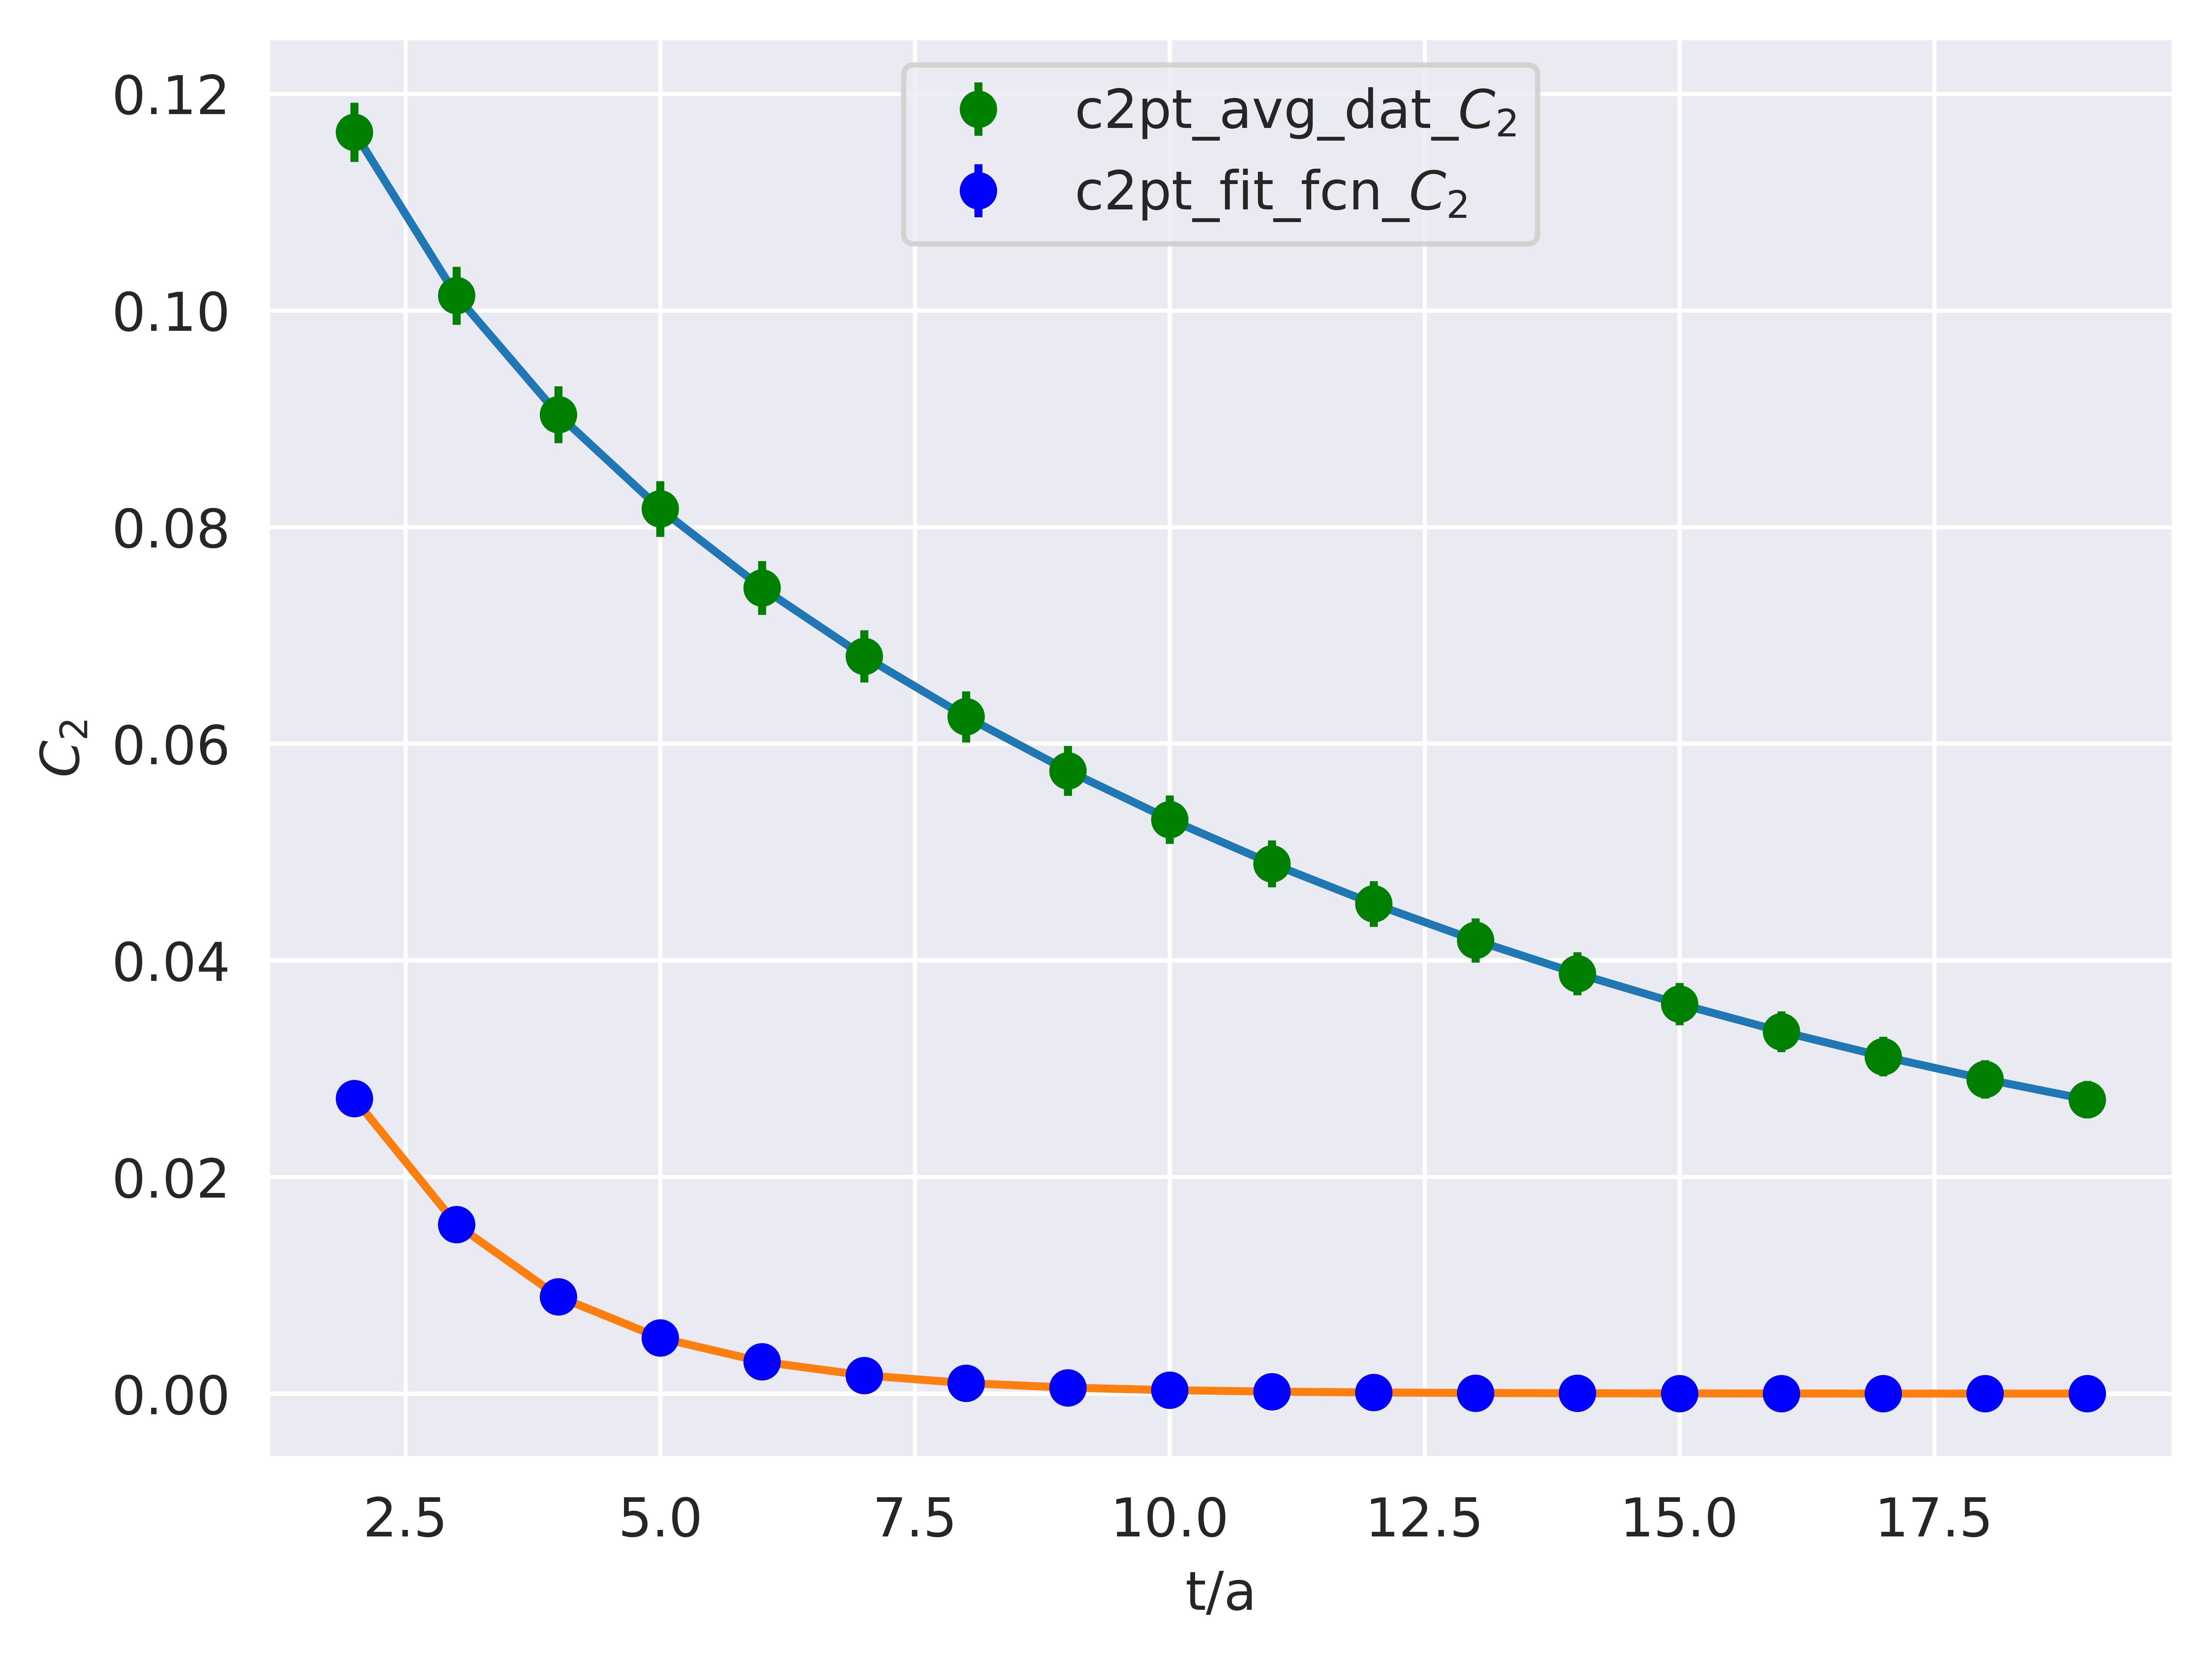

In [73]:
T_start = 2
T_end = 19
small_time=100000.0
c2pt_jcknf = np.array([i["jk_real"].values for i in df_list]) / small_time
fit = fit_c2tp(c2pt_jcknf=c2pt_jcknf, fcn=fcn, T_start=T_start, T_end=T_end)

# test

In [74]:
# pd.set_option("display.max_rows", None)
# for i in df_list:
#     print(i)

In [75]:
# np.set_printoptions(threshold=np.inf)
# for i in df_list:
#     print(i["jk_real"].values)

In [76]:
# df_list

In [77]:
# print(np.array([i["jk_real"].values for i in df_list]))

In [78]:
# import numpy as np
# import gvar as gv
# import lsqfit

# y = {                                 # data for the dependent variable
#    'data1' : gv.gvar([1.376, 2.010], [[ 0.0047, 0.01], [ 0.01, 0.056]]),
#    'data2' : gv.gvar([1.329, 1.582], [[ 0.0047, 0.0067], [0.0067, 0.0136]]),
#    'b/a'   : gv.gvar(2.0, 0.5)
#    }
# x = {                                 # independent variable
#    'data1' : np.array([0.1, 1.0]),
#    'data2' : np.array([0.1, 0.5])
#    }
# prior = {}
# prior['a'] = gv.gvar(0.5, 0.5)
# prior['b'] = gv.gvar(0.5, 0.5)

# def fcn(x, p):                        # fit function of x and parameters p
#   ans = {}
#   for k in ['data1', 'data2']:
#      ans[k] = gv.exp(p['a'] + x[k] * p['b'])
#   ans['b/a'] = p['b'] / p['a']
#   return ans

# # do the fit
# print(x)
# fit = lsqfit.nonlinear_fit(data=(x, y), prior=prior, fcn=fcn, debug=True)
# print(fit.format(maxline=True))       # print standard summary of fit

# # p = fit.p                             # best-fit values for parameters
# # outputs = dict(a=p['a'], b=p['b'])
# # outputs['b/a'] = p['b']/p['a']
# # inputs = dict(y=y, prior=prior)
# # print(gv.fmt_values(outputs))              # tabulate outputs
# # print(gv.fmt_errorbudget(outputs, inputs)) # print error budget for outputs

In [79]:
# import gvar as gv

# # 定义中心值和协方差矩阵
# c2pt_avg_cntrl = np.array([1.0, 2.0, 3.0])
# c2pt_avg_cov = np.array([[0.1, 0.2, 0.3],
#                 [0.2, 0.3, 0.4],
#                 [0.3, 0.4, 0.5]])

# # 创建 gvar 对象
# c2pt_avg_gv = gv.gvar(c2pt_avg_cntrl, c2pt_avg_cov)

# # 输出 gvar 对象
# print(c2pt_avg_gv)
# c2pt_avg_cov-c2pt_avg_cntrl


In [80]:
# import numpy as np
# from scipy.optimize import curve_fit

# # 定义一个非线性函数模型
# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c

# # 生成带有噪声的数据
# xdata = np.linspace(0, 4, 50)
# y = func(xdata, 2.5, 1.3, 0.5)
# np.random.seed(42)
# ydata = y + 0.2 * np.random.normal(size=len(xdata))

# # 生成带有不确定度的y值数组
# yerr = 1 + 0.2 * np.random.normal(size=len(xdata))

# # 使用curve_fit函数拟合数据
# popt, pcov = curve_fit(func, xdata, ydata, sigma=yerr)

# # 输出拟合参数及其标准差
# print('拟合参数:', popt)
# print('标准差:', np.sqrt(np.diag(pcov)))


In [81]:
# import numpy as np
# import scipy.optimize as opt
# import matplotlib.pyplot as plt
# import seaborn as sns

# # Define the model function to fit
# def model_function(x, a, b, c):
#     return a * np.exp(-b * x) + c

# # Generate some noisy data to fit
# x_data = np.linspace(0, 4, 50)
# y_data = model_function(x_data, 2.5, 1.3, 0.5) + np.random.normal(0, 0.1, len(x_data))

# # Define the sigma (yerr) to use in curve_fit
# yerr = np.ones_like(y_data) * 0.1

# # Define the fit function and perform the fit
# def fit_function(x, a, b, c):
#     return a * np.exp(-b * x) + c

# popt, pcov = opt.curve_fit(fit_function, x_data, y_data, sigma=yerr)

# # Calculate the fitted standard deviation
# residuals = y_data - fit_function(x_data, *popt)
# reduced_chi_squared = np.sum(residuals**2 / yerr**2) / (len(y_data) - 3)
# fitted_std_dev = np.sqrt(np.diag(pcov) * reduced_chi_squared)

# # Calculate chi-squared and logGBF
# chi_squared = np.sum(residuals**2 / yerr**2)
# logGBF = -0.5 * (chi_squared + len(popt) * np.log(len(x_data)))

# # Print the results
# print("Fitted parameters:", popt)
# print("Fitted standard deviations:", fitted_std_dev)
# print("Chi-squared:", chi_squared)
# print("LogGBF:", logGBF)

# # Plot the original data with error bars and the fitted curve
# fig, ax = plt.subplots()
# sns.set_style("darkgrid")
# ax.errorbar(x_data, y_data, yerr=yerr, fmt='o', label='data')
# ax.plot(x_data, fit_function(x_data, *popt), label='fit')
# ax.legend()
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_title('Nonlinear fit with noise\n' + r'$\chi^2$: {:.3f}, LogGBF: {:.3f}'.format(chi_squared, logGBF))

# # Calculate the uncertainty of the fitted parameters
# parameter_uncertainty = np.sqrt(np.diag(pcov))

# # Print the uncertainty of the fitted parameters
# print("Parameter uncertainty:", parameter_uncertainty)

# # Add the uncertainty and chi2 and logGBF to the plot
# textstr = r'$\sigma_a$: {:.3f}, $\sigma_b$: {:.3f}, $\sigma_c$: {:.3f}'.format(*parameter_uncertainty)
# textstr += '\n' + r'$\chi^2$: {:.3f}, LogGBF: {:.3f}'.format(chi_squared, logGBF)
# plt.text(0.05, 0.95, textstr, transform=ax.transAxes, fontsize=14, verticalalignment='top')

# plt.show()
